In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
data = pd.read_csv('All_Extracted_Data_From_PDFs.csv')
topic = 'Health care'

In [3]:
def topic_df(topic):
    yearset = set(data.Year)
    codeset = set(data.Country_Code)
    countryset = set(data.Country)
    topic_data = data.loc[lambda data: data['Topic'] == topic]
    pre_dict = {'Country':[],'Country_Code':[],'Region':[],'Year':[],'Amount':[]}
    pre_DF = pd.DataFrame(pre_dict)
    for country in countryset:
        for year in yearset:
            for i in topic_data.index:
                if topic_data.Country[i] == country and topic_data.Year[i] == year:
                    df = pd.DataFrame([[country,topic_data.Country_Code[i],topic_data.Region[i],year,topic_data.Amount_in_usd[i]]],columns = pre_DF.columns)
                    pre_DF = pre_DF.append(df)
    pre_DF.reset_index()
    amount_sum_dict={'Country_Code':[],'Region':[],'Year':[],'Amount_sum':[]}
    amount_sum_DF =pd.DataFrame(amount_sum_dict)
    for code in codeset:
        df = pre_DF.loc[lambda pre_DF: pre_DF['Country_Code'] == code]
        region = np.nan
        if len(df.Region) > 0:
            region = list(set(df.Region))[0]
        if len(df.Year)>0:
            for year in df.Year:
                amount_sum = pre_DF.loc[(pre_DF['Country_Code'] == code) & (pre_DF['Year'] == year)]['Amount'].sum()
                df2 = pd.DataFrame([[code,region,year,amount_sum]],columns = amount_sum_DF.columns)
                amount_sum_DF = amount_sum_DF.append(df2)
    amount_sum_DF= amount_sum_DF.drop_duplicates(subset ="Amount_sum")
    amount_sum_DF = amount_sum_DF.reset_index()
    return amount_sum_DF

In [4]:
otherdata = pd.read_csv('mortalityrate.csv')

In [5]:
def compute_WB_data(wbdata,code,year):
    value = np.nan
    for j in wbdata.index:
            if wbdata.iloc[j,1] == code:
                for col in wbdata.columns:
                    if wbdata[col].iloc[3] == year:
                        value = wbdata[col].iloc[j]
                        break
    return value

In [6]:
impact_DF = topic_df(topic)

In [7]:
impact_DF

,index,Country_Code,Region,Year,Amount_sum
0,0,ECU,Latin America & Caribbean,1993.0,70000000.0
1,0,GTM,Latin America & Caribbean,2007.0,49000000.0
2,0,GTM,Latin America & Caribbean,2019.0,100000000.0
3,0,KAZ,Europe & Central Asia,1999.0,42500000.0
4,0,KAZ,Europe & Central Asia,2008.0,117700000.0
...,...,...,...,...,...
86,0,IRN,Middle East & North Africa,1993.0,141400000.0
87,0,IRN,Middle East & North Africa,2000.0,87000000.0
88,0,CHN,East Asia & Pacific,2017.0,600000000.0
89,0,CHN,East Asia & Pacific,2018.0,118000000.0


In [8]:
def topic_and_other(impact_DF,otherdata):
    impact_DF['-2'] = None
    impact_DF['-1'] = None
    impact_DF['0'] = None
    impact_DF['1'] = None
    impact_DF['2'] = None
    impact_DF['3'] = None
    impact_DF['4'] = None
    impact_DF['5'] = None    
    for k in range(-2,6):
        for i in impact_DF.index:
            code = impact_DF.Country_Code[i]
            year = impact_DF.Year[i] + k
            other = compute_WB_data(otherdata,code,year)
            impact_DF[str(k)][i] = other
    return impact_DF   

In [9]:
df = topic_and_other(impact_DF,otherdata)

<ipython-input-8-74b1e620eb15>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impact_DF[str(k)][i] = other


In [10]:
def region_code(region):
    code = np.nan
    if region == 'Latin America & Caribbean ':
        code = 'LCN'
    if region == 'East Asia & Pacific':
        code = 'EAS'
    if region == 'South Asia':
        code = 'SAS'
    if region == 'Middle East & North Africa':
        code = 'MEA'
    if region == 'Europe & Central Asia':
        code = 'ECS'
    return code

In [18]:
df['Delta_country'] = None
df['Delta_region'] = None
df['Delta']=None
for i in df.index:
    year = df.Year[i]
    region = df.Region[i]
    reg_code = region_code(region)
    del_regi = (compute_WB_data(otherdata,reg_code,year+2) - compute_WB_data(otherdata,reg_code,year))/compute_WB_data(otherdata,reg_code,year)
    del_count = (df.iloc[i,10] - df.iloc[i,5])/df.iloc[i,5]
    df['Delta_country'][i] = -del_count
    df['Delta_region'][i] = -del_regi
    df['Delta'][i] = - del_regi + del_count

<ipython-input-18-a75783fa007a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Delta_country'][i] = -del_count
<ipython-input-18-a75783fa007a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Delta_region'][i] = -del_regi
<ipython-input-18-a75783fa007a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Delta'][i] = - del_regi + del_count


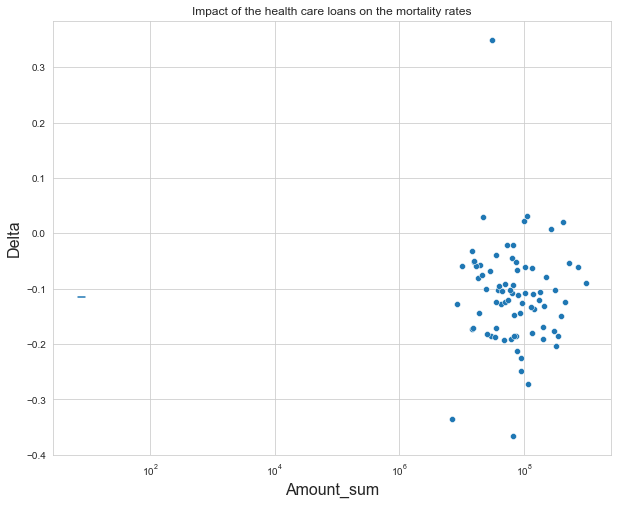

In [31]:
plt.figure(figsize = (10,8))


sns.scatterplot(data = df, x="Amount_sum", y = "Delta")
plt.xlabel("Amount_sum", fontsize =16)
plt.xscale("log")

## place a ylabel
plt.ylabel("Delta", fontsize = 16)

plt.title("Impact of the health care loans on the mortality rates")
## type this to show the plot
plt.show()

In [16]:
plt.close()

In [21]:
dfdf = df.dropna(subset = ["Delta_region","Delta_country"])

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
slr = LinearRegression(copy_X = True)
slr.fit(dfdf["Amount_sum"].values.reshape(-1,1),dfdf["Delta"].values)

LinearRegression()

In [29]:
a = slr.coef_[0]
a

1.7780328021859564e-11

In [30]:
b = slr.intercept_
b

-0.11433940182953303